In [30]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
import pandas as pd
from IPython.display import Image, display
import random
#import os

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs

# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)

	return array(cleaned) 

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename1 = 'fre.txt'
doc1 = load_doc(filename1)
filename2 = 'input_fr.txt'
doc2 = load_doc(filename2)
#print(doc)
# split into english-german pairs
pairs1 = to_pairs(doc1)
pairs2 = to_pairs(doc2)
#temp=array(pairs)
# clean sentences
clean_pairs_ = clean_pairs(pairs1)
clean_pairs_t = clean_pairs(pairs2)
# save clean pairs to file
save_clean_data(clean_pairs_, 'english-german.pkl')
save_clean_data(clean_pairs_t,'english-german-t.pkl')
# spot check
for i in range(2):
	print(clean_pairs_t[i,:])


Saved: english-german.pkl
Saved: english-german-t.pkl
['x'
 'paris est humide au mois de novembre mais il est parfois beau en aout']
['x'
 'californie est neigeux au mois de novembre et il est jamais pluvieux en fevrier']


In [76]:
def gif():
    listofimages = ['smiley2.gif','mrbean2.gif','mrbean3.gif','mrbean4.gif','mrbean5.gif','mbean4.gif']
    display(Image(filename=random.choice(listofimages)))           

In [22]:
from pickle import load
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
raw_dataset = load_clean_sentences('english-german.pkl')
raw_dataset2 = load_clean_sentences('english-german-t.pkl')

# reduce dataset size
n_sentences = 10000
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:9000], dataset[9000:]
# save
save_clean_data(dataset, 'english-german-both.pkl')
save_clean_data(train, 'english-german-train.pkl')
save_clean_data(test, 'english-german-test.pkl')
save_clean_data(raw_dataset2,'english-german-test-t.pkl')

Saved: english-german-both.pkl
Saved: english-german-train.pkl
Saved: english-german-test.pkl
Saved: english-german-test-t.pkl


In [37]:
from pickle import load
import pydot
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(LSTM(n_units))
	model.add(RepeatVector(tar_timesteps))
	model.add(LSTM(n_units, return_sequences=True))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
test_t = load_clean_sentences('english-german-test-t.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length))

# prepare training data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)
# prepare validation data
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

# define model
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
#plot_model(model, to_file='model.png', show_shapes=True)    "error(pydot can't import)"
# fit model
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

English Vocabulary Size: 199
English Max Length: 15
German Vocabulary Size: 315
German Max Length: 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 19, 256)           80640     
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               525312    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 15, 256)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 256)           525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 199)           51143     
Total params: 1,182,407
Trainable params: 1,182,407
Non-trainable params: 0
_________________________________________________________________
None
Train on 9000 samples, va

In [ ]:
#test_t = load_clean_sentences('english-german-test-t.pkl')

In [32]:
from pickle import load
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, eng_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], predicted=[%s]' % (raw_src, translation))
		actual.append(raw_target.split())
		predicted.append(translation.split())
	#calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-german-both.pkl')
train = load_clean_sentences('english-german-train.pkl')
test = load_clean_sentences('english-german-test.pkl')
test_t=load_clean_sentences('english-german-test-t.pkl')
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
# prepare german tokenizer
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
testX = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
testx_t=encode_sequences(ger_tokenizer,ger_length,test_t[:, 1])
#our input
# load model
model = load_model('model.h5')
# test on some training sequences
print('train')
evaluate_model(model, eng_tokenizer, trainX, train)
# test on some test sequences
print('trainX')
evaluate_model(model, eng_tokenizer, testX, test)
#print('input')
#evaluate_model(model,eng_tokenizer,testx_t,test_t)

train
src=[les etatsunis est generalement froid pendant l hiver mais il est froid en novembre], predicted=[the united states is usually cold during winter but it is chilly in november]
src=[elle aime le pamplemousse les mangues et citrons verts], predicted=[she likes grapefruit mangoes and limes]
src=[elle aime les raisins et le pamplemousse], predicted=[she likes grapes and grapefruit]
src=[les etatsunis est parfois sec pendant l ete mais il gele habituellement en aout], predicted=[the united states is sometimes dry during summer but it is usually freezing in august]
src=[l inde est jamais doux pendant l hiver mais jamais de neige en aout], predicted=[india is never march during winter but it is never snowy in august]
src=[nous aimons les oranges les peches et les bananes], predicted=[we like oranges peaches and bananas]
src=[lorange est notre fruit prefere mais la peche est son favori], predicted=[the orange is our favorite fruit but the peach is his favorite]
src=[les etatsunis est 

C:\Users\srinivas\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.002494
BLEU-2: 0.049937
BLEU-3: 0.165598
BLEU-4: 0.223467
trainX
src=[la mangue est notre fruit moins aime mais le citron est mon moins aime], predicted=[the mango is our least liked fruit but the lemon is my least liked]
src=[la fraise est votre fruit le plus aime mais le raisin est leur plus aime], predicted=[the grape is your favorite fruit but the apple is their least]
src=[l inde est jamais a sec au mois de novembre mais il est generalement doux en janvier], predicted=[india is never dry during november but it is usually march in january]
src=[l inde est parfois humide au mois de novembre et il est parfois calme a l automne], predicted=[india is sometimes wet during november and it is sometimes quiet in fall]
src=[jaime les oranges et les mangues], predicted=[i like oranges and mangoes]
src=[il est alle aux etatsunis en novembre dernier], predicted=[he went to the united states last november]
src=[les etatsunis est generalement agreable en janvier et il est agreable en s

In [91]:
result = list()
def print_predicted(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list();gif()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        if i < 10:
            #print('src=[%s], predicted=[%s]' % (raw_src, translation))
            result.append(translation)
            print('%s'%(translation))
        actual.append(raw_target.split())
        predicted.append(translation.split())

Saved: english-german-t.pkl
Saved: english-german-test-t.pkl


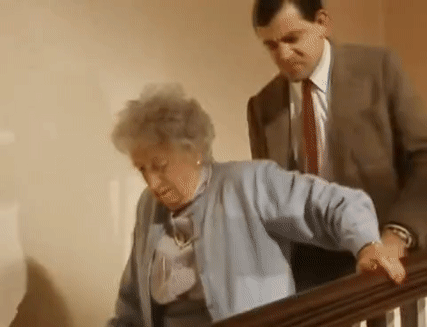

paris is wet during november but it is sometimes beautiful in august
california is snowy during november and it is never rainy in february
he dislikes mangoes apples and oranges
california is sometimes beautiful during november but it is relaxing in february


In [96]:
#Taking input
filename2 = 'input_fr.txt'
doc2 = load_doc(filename2)
clean_pairs_t = clean_pairs(pairs2)
save_clean_data(clean_pairs_t,'english-german-t.pkl')
raw_dataset2 = load_clean_sentences('english-german-t.pkl')
save_clean_data(raw_dataset2,'english-german-test-t.pkl')
test_t=load_clean_sentences('english-german-test-t.pkl')
testx_t=encode_sequences(ger_tokenizer,ger_length,test_t[:, 1])
print_predicted(model,eng_tokenizer,testx_t,test_t)

In [93]:
print(result)

['paris is wet during november but it is sometimes beautiful in august', 'california is snowy during november and it is never rainy in february', 'he dislikes mangoes apples and oranges', 'california is sometimes beautiful during november but it is relaxing in february']


Text(0.5,1,'Top 10 Words')

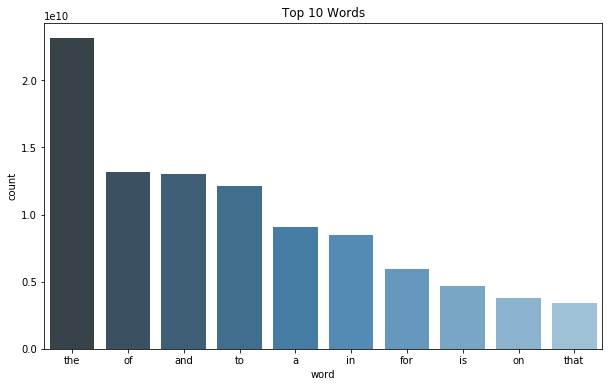

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


df = pd.read_csv("unigram_freq.csv")
df.head(10)


top10 = df.iloc[0:10]
plt.figure(figsize=(10,6))
sns.barplot("word", "count", data=top10, palette="Blues_d").set_title("Top 10 Words")




In [108]:
df.iloc[:,1][0]

23135851162

In [124]:
res=dict()
for line in result:
    print(line)
    words=line.split()
    for word in words:
        print(word)
        if word not in res:
            if word == ' ':
                continue
            ind=list(df.iloc[:,0]).index(word)
            #print(ind)
            res[word]=df.iloc[:,1][ind]

paris is wet during november but it is sometimes beautiful in august
paris
is
wet
during
november
but
it
is
sometimes
beautiful
in
august
california is snowy during november and it is never rainy in february
california
is
snowy
during
november
and
it
is
never
rainy
in
february
he dislikes mangoes apples and oranges
he
dislikes
mangoes
apples
and
oranges
california is sometimes beautiful during november but it is relaxing in february
california
is
sometimes
beautiful
during
november
but
it
is
relaxing
in
february
paris is wet during november but it is sometimes beautiful in august
paris
is
wet
during
november
but
it
is
sometimes
beautiful
in
august
california is snowy during november and it is never rainy in february
california
is
snowy
during
november
and
it
is
never
rainy
in
february
he dislikes mangoes apples and oranges
he
dislikes
mangoes
apples
and
oranges
california is sometimes beautiful during november but it is relaxing in february
california
is
sometimes
beautiful
during
nove

In [132]:
import operator
sorted_x = sorted(res.items(), key=operator.itemgetter(1),reverse=True)
print(sorted_x)

[('and', 12997637966), ('in', 8469404971), ('is', 4705743816), ('it', 2813163874), ('but', 999899654), ('he', 842847219), ('during', 206364495), ('november', 163308383), ('never', 149556758), ('august', 139459917), ('february', 127704851), ('california', 119376975), ('beautiful', 58503804), ('paris', 48831449), ('sometimes', 47402973), ('wet', 23918294), ('relaxing', 4733863), ('apples', 4024590), ('rainy', 2469088), ('snowy', 1631719), ('oranges', 1523633), ('dislikes', 692897), ('mangoes', 177518)]


In [133]:
sorted_x[0][0]

'and'

In [134]:
word_p=[]
index_p=[]
for i in range(len(sorted_x)):
    word_p.append(sorted_x[i][0])
    index_p.append(sorted_x[i][1])
    

<Container object of 10 artists>

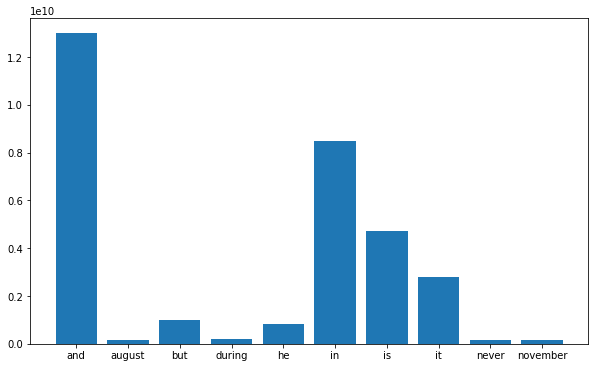

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(word_p[0:10],index_p[0:10])